# A1

In [1]:
# Standard imports
import math
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from scipy import integrate
import hh_model
import a1_solution

## Some supplied helper functions

In [2]:
def GenSignal(T, dt, rms, bandwidth, randomSeed=None):
    '''
    x = GenSignal(T, dt, rms, bandwidth, randomSeed)

    Generate a random signal that is bandlimited.

    Input:
      T is the total time
      dt is the time step
      rms is the root mean square
      bandwidth is [low high], in Hz
      randomseed is any integer

    Output:
      x is the signal of length T/dt + 1
    '''
    if randomSeed==None:
        randomSeed = np.random.randint(1000)
    np.random.seed(randomSeed)

    P = int( np.floor(T/dt) )   # number of time steps
    t = np.linspace(0, T, P)

    # MaxFreq = 2 pi / dts (Hz)
    delta_omega = 1.0 / T
    omega = np.array( range(0,P) )
    h = omega[int(np.ceil(float(P)/2))]
    omega = delta_omega * (np.mod(omega+h,P) - h)

    A = np.array( np.zeros([P,1]), complex)

    for k in range(P):
        if abs(omega[k])>=bandwidth[0] and abs(omega[k])<=bandwidth[1]:
            A[k] = np.random.randn() + 1j*np.random.randn()
    A[0] = np.random.randn()

    #pdb.set_trace() # this sets a breakpoint

    if (P/2==np.floor(P/2)):
       P2 = P/2 - 1
       for k in range(1,int(P2)):
            A[k] = np.conj(A[P-k])
    else:
       P2 = np.ceil(P/2) - 1
       for k in range(1,int(P2)):
            A[k] = np.conj(A[P-k])

    sample_rms = 0.0
    for k in range(P):
        sample_rms = sample_rms + A[k]*np.conj(A[k])
    sample_rms = np.sqrt( sample_rms / T * dt )
    A = A / sample_rms * rms * np.sqrt(P)

    #pdb.set_trace() # this sets a breakpoint
    x = np.fft.ifft(A,np.shape(A)[0],0)
    x = np.real(x)

    return x

def PlotSpikeRaster(st, y_range=[0, 1.]):
    '''
    PlotSpikeRaster(spiketimes, y_range=[0, 1.])

    Plots a spike raster plot for a list of arrays of spike times.

    Input:
      spiketimes is a list of arrays of spike times, like that returned
          by the function Stim2Spikes.
      y_range is a 2-tuple that holds the y-values that the raster ticks
          should be drawn between
    '''
    N = len(st)  # number of neurons

    levels = np.linspace(y_range[0], y_range[1], N+1, endpoint=True)
    for n in range(N):
        nspikes = len(st[n])
        y = [ [levels[n]]*nspikes , [levels[n+1]]*nspikes ]
        #y = y_range[0] + [levels[n]]*nspikes
        plt.plot(np.vstack((st[n],st[n])), y, color=np.random.rand(3))
    plt.ylim(y_range)
    return

def RandomSpikeTrain(rates, T, jitter=1.):
    '''
    spike_times = RandomSpikeTrain(rates, T)
    
    Creates a spike train (as an array of time stamps).
    
    Input:
    rates is an array or list of firing rates (in Hz), one
        firing rate for each interval.
    T is an array or list (the same size as 'rates') that gives
        the time to end each interval
    jitter is a scalar that determines how much the spikes
        are randomly moved
        
    Output:
    spike_times is an array of times when spikes occurred
    '''
    s = []
    t = 0.
    for idx in range(0,len(rates)):
        Trange = T[idx] - t
        delta = 1. / rates[idx]
        N = rates[idx] * Trange
        times = np.arange(t+delta/2., T[idx], delta)
        times += np.random.normal(scale=delta*jitter, size=np.shape(times))
        t = T[idx]
        s.extend(times)
    return np.array(s)

def RunHH(Tend, dt=0.1, Jin=0.):
    '''
    t, y = RunHH(Tend, dt=0.1, Jin=0)
    
    Runs the Hodgkin-Huxley neuron model for a constant input current.
    
    Inputs:
      Tend is the ending time (in ms)
      dt is the time step (default 0.1 ms)
      Jin is the constant input current
    
    Outputs:
      t is an N-vector (array) of time stamps (in ms)
      y is an Nx4 array, with columns containing:
           1. v
           2. m
           3. h
           4. n
    '''
    z0 = [-65.,   0.053,   0.6, 0.318]
    t = np.arange(0.0, Tend, dt)  # Again, in units of ms
    y = integrate.odeint(hh_model.HHDynamics, z0, t, args=((lambda x: Jin),), hmax=dt)
    return t, y


# Q1: LIF Neuron Model

## (a) Complete LIF_Neuron function

In [3]:
def LIF_Neuron(vin, dt, tau_m=0.05, tau_ref=0.002):
    '''
    spike_times, V = LIF_Neuron(vin, dt, tau_m=0.05, tau_ref=0.002)
    
    Given the input current, outputs the spiking activity and sub-
    threshold membrane potential of a leaky integrate-and-fire neuron.
    
    Input:
      vin is a vector of length P of input currents
      dt is the time step (in seconds)
      tau_m is the membrane time constant (in seconds, default is 0.05s)
      tau_ref is the refractory period (in seconds, default is 2ms)
          
    Output:
      spike_times is an array (or list) of time-stamps indicating when
          the neuron fired.
      V is a P-vector of membrane potentials
    '''
    P = len(vin)
    v = np.zeros(P)
    spikes = []
    
    #*** YOUR CODE ***
        
    # dv / dt = (vin - v) / tau_m
    # v_next - v_current = (vin_current - v_current) / tau_m * (t_next - t_current) 
    
    v_current = 0
    ref_time = 0
    
    v[0] = 0
    
    for i in range(1, P):
        
        if(ref_time <= 0):
            v_current = v_current + (vin[i] - v_current) / tau_m * dt
            v[i] = v_current
        else:
            ref_time -= dt
        
        if(v_current >= 1):
            spikes.append(dt * i)
            v_current = 0
            ref_time = tau_ref
        
    return spikes, v

## (b) Running your function on constant input

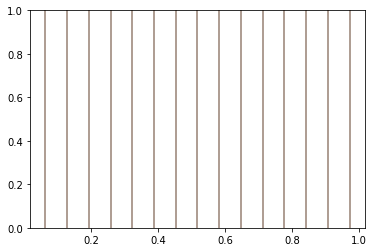

In [4]:

P = 1000
vin = 1.4 * np.ones(shape = [P, 1])
dt = 0.001

#spikes, v = a1_solution.LIF_Neuron(vin, dt)
#print(v)
spikes, v = LIF_Neuron(vin, dt)

plt.figure()
PlotSpikeRaster([spikes]);



## (c) Printing the spike rate

In [5]:
spike_rate = len(spikes) / (len(v) * dt)

print("The spike rate was %f Hz." % spike_rate)

The spike rate was 15.000000 Hz.


## (d) Running your function on a random signal
You can use the function GenSignal (defined above) to create random inputs. As an example,

    my_vin = GenSignal(2., 0.001, 2., [0.1, 2.5])

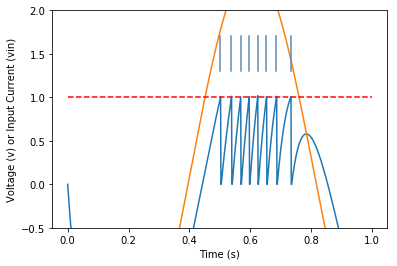

In [7]:
my_vin = GenSignal(1., 0.001, 2., [0.1, 2.5], randomSeed = 1234567)

T = 1
dt = 0.001
P = int(T / dt)
tt = np.linspace(0, T, P, endpoint=True)

#spikes, v = a1_solution.LIF_Neuron(my_vin, dt)
spikes, v = LIF_Neuron(my_vin, dt)

plt.figure()

plt.plot(tt, v)
plt.plot(tt, my_vin)
PlotSpikeRaster([spikes],[1.3, 1.7]);
plt.plot(tt, np.ones(np.shape(tt)), 'r--')

plt.ylim([-0.5, 2])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (v) or Input Current (vin)');


# Q2: Hodgkin-Huxley Firing Rate

## (a) Run HH model and plot

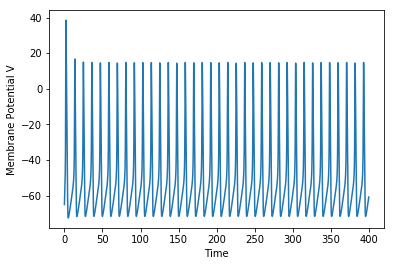

In [8]:
t, y = RunHH(400, dt = 0.1, Jin = 0.3)

plt.figure(), plt.clf()
plt.plot(t, y[:, 0])
plt.ylabel('Membrane Potential V')
plt.xlabel('Time');


## (b) Implement CountSpikes function

In [9]:
def CountSpikes(v, thresh=0.):
    '''
    spike_count = CountSpikes(v, thresh=0.)
    
    Counts the number of times the voltage in a time series crosses
    the given threshold with a positive slope.
    
    Inputs:
      v is a list or array of voltages
      thresh is the treshold (defaults to 0)
      
    Output:
      spike_count is a scalar, indicating the number of threshold
        crossings
    '''
    P = len(v)
    spike_count = 0
    
    #*** YOUR CODE ***
    
    for i in range(0, P - 1):
        if v[i] < thresh and v[i + 1] >= thresh :
            spike_count += 1

    return spike_count

## (c) Firing-rate plot

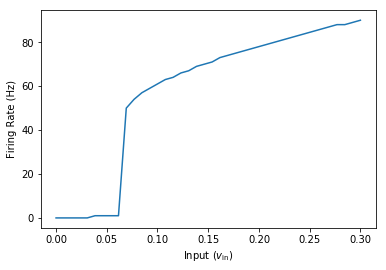

In [10]:
vin_vals = np.linspace(0, 0.3, 40)
spike_rates = []
for vin in vin_vals:
    t, y = RunHH(1000, dt = 0.1,  Jin = vin)
    n_spikes = CountSpikes(y[:, 0])
    spike_rates.append(n_spikes)

plt.figure()
plt.plot(vin_vals, spike_rates)
plt.ylabel('Firing Rate (Hz)')
plt.xlabel('Input ($v_\mathrm{in}$)');


# Q3: Synaptic Current

## (a) Complete SpikeTrain2PSC function

In [17]:
def PSC(t, offset, tau_s, n):
    '''
    Compute the PSC funtion value at t
    Inputs:
        t is the time
        offset is the time of spiking
        tau_s is synaptic time constant
        n is the order of synaptic filer
        
    Outputs:
        one value, indicating the PSC function value at t
    '''
    
    if(t <= offset):
        return 0
    else:
        return (t - offset) ** n * np.exp(-(t - offset) / tau_s) / (math.factorial(n) * tau_s ** (n + 1))
    
# SpikeTrain2PSC
def SpikeTrain2PSC(tvec, spikes, tau_s, n):
    '''
    psc = SpikeTrain2PSC(tvec, spikes, tau_s, n)
    
    Convolves a spike train with a synaptic filter.
    
    Inputs:
      tvec is a list or array of time
      spikes is a list or array of spike times
      tau_s is the synaptic time constant
      n is the order of the synaptic filter
      
    Output:
      psc is an array the same length as tvec, storing
            the corresponding post-synaptic currents
    '''
    psc = np.zeros(len(tvec))
    
    #*** YOUR CODE ***
    
    for i in range(0, len(tvec)):
        for j in range(0, len(spikes)):
            psc[i] += PSC(tvec[i], spikes[j], tau_s, n)
    
    
    return psc

In [18]:
# In case you don't trust your own implementation of
# SpikeTrain2PSC
import a1_solution


## (b) Run SpikeTrain2PSC on random spike train

Convolve that with the synaptic filter.

In [19]:
tt = np.linspace(0, 8, int(8 / 0.01))

s = RandomSpikeTrain([10, 60, 20, 45], [2, 4, 6, 8])


([<matplotlib.lines.Line2D at 0x1ba5d9a6e48>],
 Text(0.5,0,'Time (s)'),
 Text(0,0.5,'Post-Synaptic Current'))

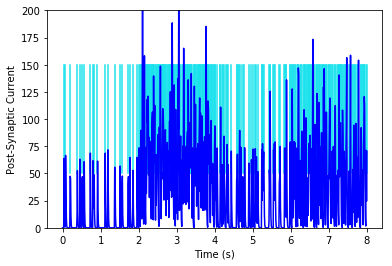

In [23]:
# tau_s = 5ms

#psc = a1_solution.SpikeTrain2PSC(tt, s, 0.005, 1)
psc = SpikeTrain2PSC(tt, s, 0.005, 1)

plt.figure()
PlotSpikeRaster([s], y_range = (50, 150))
plt.ylim([0, 200])
plt.plot(tt,psc,'b'), plt.xlabel('Time (s)'), plt.ylabel('Post-Synaptic Current')

([<matplotlib.lines.Line2D at 0x1ba5dcca978>],
 Text(0.5,0,'Time (s)'),
 Text(0,0.5,'Post-Synaptic Current'))

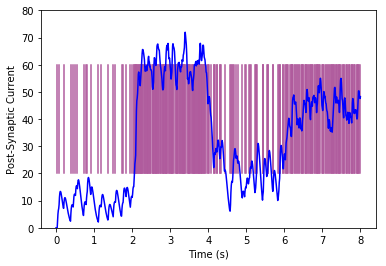

In [24]:
# tau_s = 50ms

#psc = a1_solution.SpikeTrain2PSC(tt, s, 0.05, 1)
psc = SpikeTrain2PSC(tt, s, 0.05, 1)

plt.figure()
PlotSpikeRaster([s], y_range = (20, 60))
plt.ylim([0, 80])
plt.plot(tt,psc,'b'), plt.xlabel('Time (s)'), plt.ylabel('Post-Synaptic Current')

([<matplotlib.lines.Line2D at 0x1ba5efc00b8>],
 Text(0.5,0,'Time (s)'),
 Text(0,0.5,'Post-Synaptic Current'))

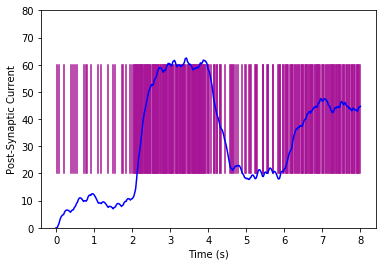

In [25]:
# tau_s = 150ms

#psc = a1_solution.SpikeTrain2PSC(tt, s, 0.15, 1)
psc = SpikeTrain2PSC(tt, s, 0.15, 1)

plt.figure()
PlotSpikeRaster([s], y_range = (20, 60))
plt.ylim([0, 80])
plt.plot(tt,psc,'b'), plt.xlabel('Time (s)'), plt.ylabel('Post-Synaptic Current')


## (c) Affect of changing $\tau_s$

When the firing rate is high, the value of PSC is high. When the firing rate is low, the value of PSC is low.

As tau_s goes larger, the curve tends to be more smooth. The fluctuation, respect to the firing rate, tends to be less intensive.


# Q4: Combining Spike Trains

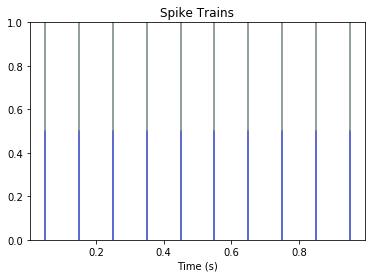

In [26]:
sA = RandomSpikeTrain([10], [1], jitter=0.)
sB = RandomSpikeTrain([10], [1], jitter=0.)
PlotSpikeRaster([sA, sB])
plt.xlabel('Time (s)'); plt.title('Spike Trains');

## (a) SpikesAB2C

In [27]:
# If you don't trust your own code for
# LIF_Neuron and SpikeTrain2PSC...
#import a1_solution

In [28]:
def SpikesAB2C(st, w, tau_s):
    '''
    spikes = SpikesAB2C(st_list, weights, tau_s)
    
    Combines two incoming spike trains and generates the resulting
    spike train of the receiving LIF neuron.
    
    Inputs:
      st_list is a list containing two spike trains (arrays)
      weights is a list containing the two connection weights
          corresponding to the two input spike trains
      tau_s is the synaptic time constant in seconds
        
    Output:
      spikes is an array of spike times
    
    Notes:
      This function assume the LIF neuron's membrane time
      constant is 20ms.
    '''

    spikes = []
    
    #*** YOUR CODE HERE ***
    T =  max(max(st[0]), max(st[1]))+ 2 * tau_s
    
    tt = np.linspace(0, T, int(T / 0.001))
    
    psc0 = a1_solution.SpikeTrain2PSC(tt, st[0], tau_s, 1)
    psc1 = a1_solution.SpikeTrain2PSC(tt, st[1], tau_s, 1)
    psc = w[0] * psc0 + w[1] * psc1
    
    spikes, v = a1_solution.LIF_Neuron(psc, 0.001, tau_m = 0.02)
    
    return np.array(spikes)


## (b.i) Synchronized spike trains using $\tau_s = 0.002$ seconds

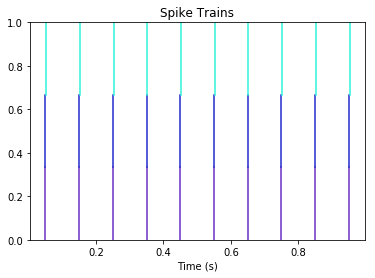

In [29]:
tau_s = 0.002
w = [0.025, 0.025]

sC = SpikesAB2C([sA, sB], w, tau_s)

PlotSpikeRaster([sA, sB, sC])
plt.xlabel('Time (s)'); plt.title('Spike Trains');

## (b.ii) Delayed spike trains using $\tau_s = 0.002$ seconds

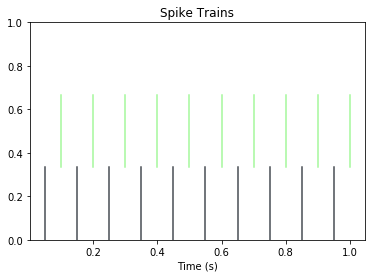

In [30]:
tau_s = 0.002
w = [0.025, 0.025]

sB_p = sB + 0.05

sC = a1_solution.SpikesAB2C([sA, sB_p], w, tau_s)
#sC = SpikesAB2C([sA, sB_p], w, tau_s)

PlotSpikeRaster([sA, sB_p, sC])
plt.xlabel('Time (s)'); plt.title('Spike Trains');

## (b.iii) Synchronized spike trains using $\tau_s = 0.05$ seconds

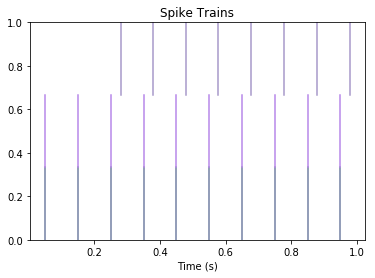

In [31]:
tau_s = 0.05
w = [0.05, 0.05]

sC = a1_solution.SpikesAB2C([sA, sB], w, tau_s)
#sC = SpikesAB2C([sA, sB], w, tau_s)

PlotSpikeRaster([sA, sB, sC])
plt.xlabel('Time (s)'); plt.title('Spike Trains');

## (b.iv) Delayed spike trains using $\tau_s = 0.05$ seconds

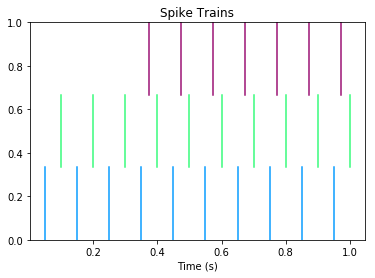

In [451]:
tau_s = 0.05
w = [0.05, 0.05]

sC = a1_solution.SpikesAB2C([sA, sB_p], w, tau_s)
#sC = SpikesAB2C([sA, sB_p], w, tau_s)

PlotSpikeRaster([sA, sB_p, sC])
plt.xlabel('Time (s)'); plt.title('Spike Trains');

## (c) Interpret

YOUR ANSWER HERE

In [ ]:
For synchronized spikes train, larger tau_s delayed the spike train of C.

For delayed spikes train, small tau_s results in no spike train of C. Only larger tau_s can produce the spike of C.
